In [2]:

import torch_geometric.utils as pyg_utils
import time
from datetime import datetime
import networkx as nx

import torch.optim as optim
from torch_geometric.datasets import TUDataset
from torch_geometric.data import DataLoader
from tensorboardX import SummaryWriter

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.nn import GCNConv

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [3]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

In [4]:
def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(out.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

# Cora dataset

In [5]:
dataset = Planetoid(root='/tmp/cora', name='cora', transform=NormalizeFeatures())

In [6]:
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}\n')

data = dataset[0]  # Get the first graph object.

print(data)
print('==============================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
print(f'Contains self-loops: {data.contains_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Dataset: cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(edge_index=[2, 10556], test_mask=[2708], train_mask=[2708], val_mask=[2708], x=[2708, 1433], y=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


In [6]:
print('Train label : ',data.train_mask.sum().item())
print('Val label : ',data.val_mask.sum().item())
print('Test label :',data.test_mask.sum().item())

Train label :  140
Val label :  500
Test label : 1000


In [280]:
data.train_mask[70:]=False

In [282]:
data.train_mask

tensor([ True,  True,  True,  ..., False, False, False])

In [283]:
data.val_mask

tensor([False, False, False,  ..., False, False, False])

# Node Classification

## GCN

In [284]:
class GCN(nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
       # torch.cuda.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


In [285]:
model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

In [10]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask]) # Compute the loss solely based on the training nodes
    pred = out.argmax(dim=1)
    train_correct = pred[data.train_mask] == data.y[data.train_mask]
    train_acc = train_correct.sum().item() / torch.sum(data.train_mask==True).item()
    loss.backward()
    optimizer.step()
    return loss, train_acc

def val():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1) 
    val_correct = pred[data.val_mask] == data.y[data.val_mask]
    val = int(val_correct.sum()) / int(data.val_mask.sum())
    
    return val  

def test():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1) 
    test_correct = pred[data.test_mask] == data.y[data.test_mask]
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
    
    return test_acc

In [287]:
L = np.array([])

for epoch in range(1,200):
    loss, acc = train()
    val_acc = val()
    L = np.append(L,loss.item())
    print(f'Epoch: {epoch:03d}, Train Acc: {acc:.4f}, TrainLoss: {loss:.4f}, Val Acc: {val_acc:.4f}')

Epoch: 001, Train Acc: 0.1429, TrainLoss: 1.9467, Val Acc: 0.1840
Epoch: 002, Train Acc: 0.2000, TrainLoss: 1.9382, Val Acc: 0.3220
Epoch: 003, Train Acc: 0.3571, TrainLoss: 1.9285, Val Acc: 0.3020
Epoch: 004, Train Acc: 0.3571, TrainLoss: 1.9179, Val Acc: 0.2100
Epoch: 005, Train Acc: 0.3286, TrainLoss: 1.9066, Val Acc: 0.1960
Epoch: 006, Train Acc: 0.4000, TrainLoss: 1.8954, Val Acc: 0.2080
Epoch: 007, Train Acc: 0.3857, TrainLoss: 1.8817, Val Acc: 0.2520
Epoch: 008, Train Acc: 0.4857, TrainLoss: 1.8667, Val Acc: 0.3520
Epoch: 009, Train Acc: 0.5571, TrainLoss: 1.8535, Val Acc: 0.4800
Epoch: 010, Train Acc: 0.6286, TrainLoss: 1.8384, Val Acc: 0.5180
Epoch: 011, Train Acc: 0.6857, TrainLoss: 1.8293, Val Acc: 0.5480
Epoch: 012, Train Acc: 0.6714, TrainLoss: 1.8078, Val Acc: 0.5540
Epoch: 013, Train Acc: 0.7000, TrainLoss: 1.8062, Val Acc: 0.5560
Epoch: 014, Train Acc: 0.7000, TrainLoss: 1.7824, Val Acc: 0.5420
Epoch: 015, Train Acc: 0.6571, TrainLoss: 1.7709, Val Acc: 0.5140
Epoch: 016

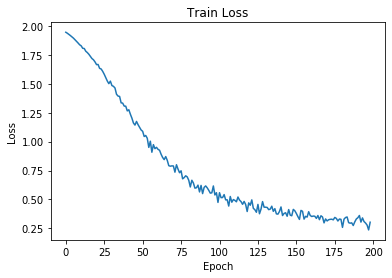

In [288]:
plt.plot(L)
plt.title('Train Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.xticks(np.arange(0, 20,step=2))

plt.show()

In [272]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8050


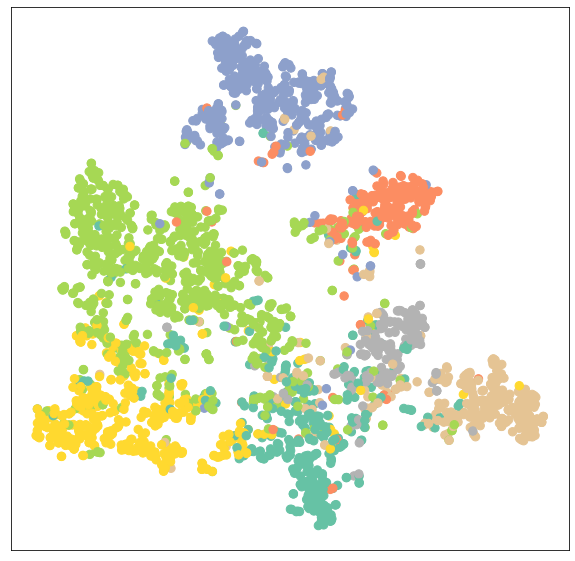

In [15]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

## GAT

In [16]:
from torch_geometric.nn import GATConv

class GAT(nn.Module):
    def __init__(self, hidden_channels):
        super(GAT, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GATConv(in_channels=dataset.num_features, out_channels=hidden_channels,heads=8,dropout=0.2)
        self.conv2 = GATConv(in_channels=hidden_channels*8, out_channels=dataset.num_classes,heads=1,dropout=0.2)
        
        self.act = nn.ELU()
        
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.act(x)
        x = self.conv2(x, edge_index)
        x = self.act(x)
        return x

model = GAT(hidden_channels=64)
print(model)

GAT(
  (conv1): GATConv(1433, 64, heads=8)
  (conv2): GATConv(512, 7, heads=1)
  (act): ELU(alpha=1.0)
)


In [17]:
model = GAT(hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=0.0005)
criterion = torch.nn.CrossEntropyLoss()

In [18]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask]) # Compute the loss solely based on the training nodes
    pred = out.argmax(dim=1)
    train_correct = pred[data.train_mask] == data.y[data.train_mask]
    train_acc = train_correct.sum().item() / torch.sum(data.train_mask==True).item()
    loss.backward()
    optimizer.step()
    return loss, train_acc

def val():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1) 
    val_correct = pred[data.val_mask] == data.y[data.val_mask]
    val = int(val_correct.sum()) / int(data.val_mask.sum())
    
    return val  

def test():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1) 
    test_correct = pred[data.test_mask] == data.y[data.test_mask]
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
    
    return test_acc

In [19]:
L = np.array([])

for epoch in range(1,100):
    loss, acc = train()
    val_acc = val()
    L = np.append(L,loss.item())
    print(f'Epoch: {epoch:03d}, Train Acc: {acc:.4f}, TrainLoss: {loss:.4f}, Val Acc: {val_acc:.4f}')

Epoch: 001, Train Acc: 0.0857, TrainLoss: 1.9460, Val Acc: 0.1260
Epoch: 002, Train Acc: 0.2214, TrainLoss: 1.9086, Val Acc: 0.2280
Epoch: 003, Train Acc: 0.4071, TrainLoss: 1.8734, Val Acc: 0.4840
Epoch: 004, Train Acc: 0.7714, TrainLoss: 1.8343, Val Acc: 0.6860
Epoch: 005, Train Acc: 0.9143, TrainLoss: 1.7900, Val Acc: 0.7580
Epoch: 006, Train Acc: 0.9286, TrainLoss: 1.7487, Val Acc: 0.7240
Epoch: 007, Train Acc: 0.9214, TrainLoss: 1.6932, Val Acc: 0.7520
Epoch: 008, Train Acc: 0.9429, TrainLoss: 1.6484, Val Acc: 0.7780
Epoch: 009, Train Acc: 0.9571, TrainLoss: 1.5759, Val Acc: 0.7880
Epoch: 010, Train Acc: 0.9429, TrainLoss: 1.5209, Val Acc: 0.7780
Epoch: 011, Train Acc: 0.9500, TrainLoss: 1.4505, Val Acc: 0.7740
Epoch: 012, Train Acc: 0.9571, TrainLoss: 1.3794, Val Acc: 0.7760
Epoch: 013, Train Acc: 0.9643, TrainLoss: 1.3294, Val Acc: 0.7740
Epoch: 014, Train Acc: 0.9286, TrainLoss: 1.2732, Val Acc: 0.7780
Epoch: 015, Train Acc: 0.9643, TrainLoss: 1.1501, Val Acc: 0.7820
Epoch: 016

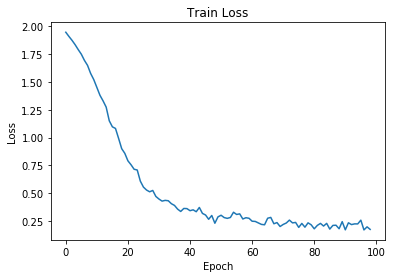

In [20]:
plt.plot(L)
plt.title('Train Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.xticks(np.arange(0, 20,step=2))

plt.show()

In [21]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8130


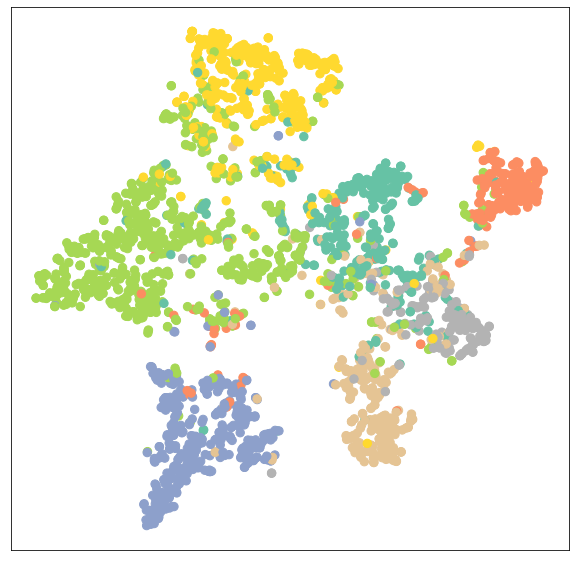

In [80]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

## GraphSAGE

In [7]:
from torch_geometric.nn import SAGEConv

In [12]:
class Sage(nn.Module):
    def __init__(self, hidden_channels):
        super(Sage, self).__init__()
       # torch.cuda.manual_seed(12345)
        self.conv1 = SAGEConv(dataset.num_features, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = Sage(hidden_channels=16)
print(model)

Sage(
  (conv1): SAGEConv(1433, 16)
  (conv2): SAGEConv(16, 7)
)


In [13]:
model = Sage(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

In [14]:
L = np.array([])

for epoch in range(1,100):
    loss, acc = train()
    val_acc = val()
    L = np.append(L,loss.item())
    print(f'Epoch: {epoch:03d}, Train Acc: {acc:.4f}, TrainLoss: {loss:.4f}, Val Acc: {val_acc:.4f}')

Epoch: 001, Train Acc: 0.1643, TrainLoss: 1.9556, Val Acc: 0.1980
Epoch: 002, Train Acc: 0.2714, TrainLoss: 1.9447, Val Acc: 0.2280
Epoch: 003, Train Acc: 0.3500, TrainLoss: 1.9301, Val Acc: 0.2300
Epoch: 004, Train Acc: 0.3714, TrainLoss: 1.9162, Val Acc: 0.2380
Epoch: 005, Train Acc: 0.3286, TrainLoss: 1.9027, Val Acc: 0.2740
Epoch: 006, Train Acc: 0.4429, TrainLoss: 1.8721, Val Acc: 0.2800
Epoch: 007, Train Acc: 0.4571, TrainLoss: 1.8536, Val Acc: 0.3020
Epoch: 008, Train Acc: 0.6000, TrainLoss: 1.8255, Val Acc: 0.3100
Epoch: 009, Train Acc: 0.6000, TrainLoss: 1.8082, Val Acc: 0.3260
Epoch: 010, Train Acc: 0.6214, TrainLoss: 1.7793, Val Acc: 0.3300
Epoch: 011, Train Acc: 0.6286, TrainLoss: 1.7730, Val Acc: 0.3460
Epoch: 012, Train Acc: 0.6786, TrainLoss: 1.7260, Val Acc: 0.3540
Epoch: 013, Train Acc: 0.6857, TrainLoss: 1.7009, Val Acc: 0.3780
Epoch: 014, Train Acc: 0.6929, TrainLoss: 1.6667, Val Acc: 0.4140
Epoch: 015, Train Acc: 0.7643, TrainLoss: 1.6244, Val Acc: 0.4360
Epoch: 016

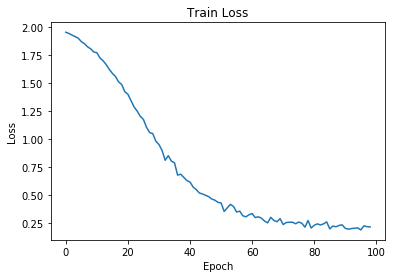

In [15]:
plt.plot(L)
plt.title('Train Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.xticks(np.arange(0, 20,step=2))

plt.show()

In [16]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.7970


# Link prediction

In [17]:
from torch_geometric.utils import train_test_split_edges
from torch_geometric.utils import negative_sampling
from sklearn.metrics import roc_auc_score

In [18]:
# Split the edges to train, val, and test
print(f'Original: {data}')
print('============================')
data.train_mask = data.val_mask = data.test_mask = data.y = None
data = train_test_split_edges(data)
print(data)

Original: Data(edge_index=[2, 10556], test_mask=[2708], train_mask=[2708], val_mask=[2708], x=[2708, 1433], y=[2708])
Data(test_neg_edge_index=[2, 527], test_pos_edge_index=[2, 527], train_neg_adj_mask=[2708, 2708], train_pos_edge_index=[2, 8976], val_neg_edge_index=[2, 263], val_pos_edge_index=[2, 263], x=[2708, 1433])


In [293]:
neg_edge_index = negative_sampling(
        edge_index=data.train_pos_edge_index, num_nodes=data.num_nodes,
        num_neg_samples=data.train_pos_edge_index.size(1))
neg_edge_index

tensor([[ 654, 2277,   74,  ...,  486, 1834, 1958],
        [1841, 1743, 2621,  ..., 1050,  167, 1372]])

In [294]:
neg_edge_index.shape

torch.Size([2, 8972])

In [297]:
model.encode()

tensor([[ 0.0013,  0.0043,  0.0013,  ..., -0.0003,  0.0016,  0.0047],
        [ 0.0045, -0.0062,  0.0022,  ...,  0.0008, -0.0033, -0.0017],
        [ 0.0036, -0.0022, -0.0009,  ..., -0.0003,  0.0007, -0.0016],
        ...,
        [ 0.0071,  0.0063, -0.0104,  ..., -0.0055,  0.0010,  0.0135],
        [ 0.0010,  0.0029,  0.0021,  ...,  0.0030,  0.0030,  0.0015],
        [ 0.0010,  0.0017,  0.0027,  ...,  0.0023,  0.0018,  0.0006]],
       device='cuda:0', grad_fn=<AddBackward0>)

In [298]:
logit

tensor([0.0008, 0.0009, 0.0006,  ..., 0.0004, 0.0006, 0.0005], device='cuda:0',
       grad_fn=<SumBackward1>)

In [311]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1 = GCNConv(dataset.num_features,128)
        self.conv2 = GCNConv(128,64)
        
    def encode(self):
        x = self.conv1(data.x, data.train_pos_edge_index)
        x = x.relu()
        return self.conv2(x,data.train_pos_edge_index)
    
    def decode(self, z, pos_edge_index, neg_edge_index):
        edge_index = torch.cat([pos_edge_index, neg_edge_index],dim=-1)
        logits = (z[edge_index[0]]* z[edge_index[1]]).sum(dim=-1)
        return logits
    
    def decode_all(self,z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
model, data = Net().to(device), data.to(device)
optimizer = torch.optim.Adam(params=model.parameters(),lr=0.01)

In [306]:
(z @ z.t()).nonzero(as_tuple=False).t()

tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
        [   0,    1,    2,  ..., 2705, 2706, 2707]], device='cuda:0')

In [310]:
(z @ z.t()).nonzero(as_tuple=False).t()[:,5:200]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0

In [20]:
def get_link_labels(pos_edge_index, neg_edge_index):
    E = pos_edge_index.size(1) + neg_edge_index.size(1)
    link_labels = torch.zeros(E, dtype=torch.float, device=device)
    link_labels[:pos_edge_index.size(1)] = 1.
    return link_labels

def train():
    model.train()
    
    neg_edge_index = negative_sampling(
        edge_index=data.train_pos_edge_index, num_nodes=data.num_nodes,
        num_neg_samples=data.train_pos_edge_index.size(1))
    
    optimizer.zero_grad()
    z = model.encode()
    link_logits = model.decode(z, data.train_pos_edge_index, neg_edge_index)
    link_labels = get_link_labels(data.train_pos_edge_index, neg_edge_index)
    loss = F.binary_cross_entropy_with_logits(link_logits, link_labels)
    loss.backward()
    optimizer.step()
    
    return loss

@torch.no_grad()
def test():
    model.eval()
    perfs = []
    for prefix in ['val', 'test']:
        pos_edge_index = data[f'{prefix}_pos_edge_index']
        neg_edge_index = data[f'{prefix}_neg_edge_index']
        
        z = model.encode()
        link_logits = model.decode(z, pos_edge_index, neg_edge_index)
        link_probs = link_logits.sigmoid()
        link_labels = get_link_labels(pos_edge_index, neg_edge_index)
        perfs.append(roc_auc_score(link_labels.cpu(), link_probs.cpu()))
    return perfs

In [313]:
best_val_perf = test_perf = 0
for epoch in range(1, 101):
    train_loss = train()
    val_perf, tmp_test_perf = test()
    if val_perf > best_val_perf:
        best_val_perf = val_perf
        test_perf = tmp_test_perf
    log = 'Epoch:{:03d}, Loss: {:.4f}, Val: {:.4f}, Test: {:.4f}]'
    print(log.format(epoch, train_loss, best_val_perf, test_perf))

z = model.encode()
final_edge_index = model.decode_all(z)

Epoch:001, Loss: 0.6930, Val: 0.6682, Test: 0.6696]
Epoch:002, Loss: 0.6812, Val: 0.6682, Test: 0.6696]
Epoch:003, Loss: 0.7173, Val: 0.6682, Test: 0.6696]
Epoch:004, Loss: 0.6768, Val: 0.6744, Test: 0.6855]
Epoch:005, Loss: 0.6849, Val: 0.7146, Test: 0.7284]
Epoch:006, Loss: 0.6890, Val: 0.7466, Test: 0.7422]
Epoch:007, Loss: 0.6903, Val: 0.7466, Test: 0.7422]
Epoch:008, Loss: 0.6900, Val: 0.7466, Test: 0.7422]
Epoch:009, Loss: 0.6886, Val: 0.7466, Test: 0.7422]
Epoch:010, Loss: 0.6857, Val: 0.7466, Test: 0.7422]
Epoch:011, Loss: 0.6812, Val: 0.7466, Test: 0.7422]
Epoch:012, Loss: 0.6781, Val: 0.7466, Test: 0.7422]
Epoch:013, Loss: 0.6784, Val: 0.7466, Test: 0.7422]
Epoch:014, Loss: 0.6752, Val: 0.7466, Test: 0.7422]
Epoch:015, Loss: 0.6692, Val: 0.7466, Test: 0.7422]
Epoch:016, Loss: 0.6640, Val: 0.7466, Test: 0.7422]
Epoch:017, Loss: 0.6592, Val: 0.7466, Test: 0.7422]
Epoch:018, Loss: 0.6527, Val: 0.7466, Test: 0.7422]
Epoch:019, Loss: 0.6439, Val: 0.7466, Test: 0.7422]
Epoch:020, L

In [314]:
final_edge_index

tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
        [   0,    2,    4,  ..., 2705, 2706, 2707]], device='cuda:0')

In [316]:
final_edge_index[:,5:30]

tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0],
        [10, 12, 13, 14, 15, 17, 18, 19, 21, 24, 25, 26, 27, 29, 30, 36, 38, 40,
         44, 45, 48, 49, 51, 54, 68]], device='cuda:0')

## GraphSage Edge prediction

In [24]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1 = SAGEConv(dataset.num_features,128)
        self.conv2 = SAGEConv(128,64)
        
    def encode(self):
        x = self.conv1(data.x, data.train_pos_edge_index)
        x = x.relu()
        return self.conv2(x,data.train_pos_edge_index)
    
    def decode(self, z, pos_edge_index, neg_edge_index):
        edge_index = torch.cat([pos_edge_index, neg_edge_index],dim=-1)
        logits = (z[edge_index[0]]* z[edge_index[1]]).sum(dim=-1)
        return logits
    
    def decode_all(self,z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
model, data = Net().to(device), data.to(device)
optimizer = torch.optim.Adam(params=model.parameters(),lr=0.01)

In [25]:
best_val_perf = test_perf = 0
for epoch in range(1, 101):
    train_loss = train()
    val_perf, tmp_test_perf = test()
    if val_perf > best_val_perf:
        best_val_perf = val_perf
        test_perf = tmp_test_perf
    log = 'Epoch:{:03d}, Loss: {:.4f}, Val: {:.4f}, Test: {:.4f}]'
    print(log.format(epoch, train_loss, best_val_perf, test_perf))

z = model.encode()
final_edge_index = model.decode_all(z)

Epoch:001, Loss: 0.6964, Val: 0.5394, Test: 0.5700]
Epoch:002, Loss: 0.6931, Val: 0.5394, Test: 0.5700]
Epoch:003, Loss: 0.6950, Val: 0.5475, Test: 0.5731]
Epoch:004, Loss: 0.6922, Val: 0.6951, Test: 0.6516]
Epoch:005, Loss: 0.6924, Val: 0.6951, Test: 0.6516]
Epoch:006, Loss: 0.6923, Val: 0.6951, Test: 0.6516]
Epoch:007, Loss: 0.6914, Val: 0.6951, Test: 0.6516]
Epoch:008, Loss: 0.6890, Val: 0.6951, Test: 0.6516]
Epoch:009, Loss: 0.6856, Val: 0.6951, Test: 0.6516]
Epoch:010, Loss: 0.6813, Val: 0.6951, Test: 0.6516]
Epoch:011, Loss: 0.6718, Val: 0.6951, Test: 0.6516]
Epoch:012, Loss: 0.6609, Val: 0.6951, Test: 0.6516]
Epoch:013, Loss: 0.6443, Val: 0.6979, Test: 0.6873]
Epoch:014, Loss: 0.6258, Val: 0.7112, Test: 0.7214]
Epoch:015, Loss: 0.5986, Val: 0.7157, Test: 0.7297]
Epoch:016, Loss: 0.5787, Val: 0.7202, Test: 0.7369]
Epoch:017, Loss: 0.5748, Val: 0.7216, Test: 0.7419]
Epoch:018, Loss: 0.5691, Val: 0.7523, Test: 0.7541]
Epoch:019, Loss: 0.5783, Val: 0.7523, Test: 0.7541]
Epoch:020, L

In [35]:
#    with open('C:/Users/USER/GNN/OpenNE/data/cora/cora_edgelist.txt', 'r') as f:
 #       text = f.read()

In [58]:
#data = text.split()
#data = [int(i) for i in data]
#source = [data[i] for i in range(len(data)) if i%2==0 ]
#target = [data[i] for i in range(len(data)) if i%2==1]

#edge_list = [(s,t) for i,(s, t) in enumerate(zip(source, target))]

In [69]:
#G = nx.Graph() #initialize一張空圖
#G.add_edges_from(edge_list)
#print('number of nodes:',G.number_of_nodes())
#print('number of edges: ',G.number_of_edges())